# Model Training, Selection, and Evaluation

In [2]:
import pandas as pd
import numpy as np
import sklearn
import pickle
import seaborn as sns
import sys

sys.path.append("..")


from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer

from sklearn import model_selection
from sklearn import linear_model, svm, naive_bayes, neighbors, ensemble, metrics
from sklearn import metrics

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

from itertools import product
from util.evaluation import confusion_matrix
from util.modeling import prepro, cross_val, get_scores, sort_scores_by_metric, get_best_params, train_best_model, tune_hyper, print_best_params

## Read in Data

Read the data, separate into X and y.

In [3]:
data = pd.read_csv("../data/data.csv")

X = data.drop(labels=["grad_bach", "survey_weight"], axis=1)
y = data["grad_bach"]


Note that the dataset is unrepresentative of the US population. In particular, Black families are oversampled; the data are also unrepresentative among other different axes. In all training and evaluation we will use survey weights in order to train and evaluate on a representative sample.

In [ ]:
weights = data["survey_weight"]

Reminder of what our features are.

In [170]:
X.columns.to_list()

['math_score',
 'reading_score',
 'wealth',
 'income',
 'environment_type',
 'age',
 'white_only',
 'black',
 'asian',
 'live_w_both_parents',
 'food_security',
 'hispanic']

Train-Test split.

In [20]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=0, stratify=y_train_val)

## Tune Hyperparameters for Various Models

### Discussion

We now tune hyperparameters using cross-validation within the training set. After arriving at the optimal hyperparameters (for our selected metric) for each model, we will then compare the models using the validation set. 


#### Metric Selection

Our ```tune_hyper``` method returns various scores for each model: accuracy, f1, f<sub>0.5</sub>, precision, and recall. We can score the methods on any of these parameters.

We choose the **f<sub>0.5</sub>-score** metric in order to evaluate the performance of each model. This metric weighs precision twice as much as recall. Thus we first penalize false positives and then false negatives. We penalize false positives more because we don't want to market to individuals who do not receive a bachelor's degree, resulting in a concrete waste of resources. False negatives are not as bad as we are simply missing out on potential bachelor's recipients, but we do still want to reach out to as many as possible.

#### Oversampling

In addition to searching over different classifier keywords, we also try different sampling methods: either no sampling or oversampling with SMOTE with various neighbor counts. The minority class is graduates, both weighted and unweighted.

We set up the oversamplers we use so we don't have to redefine.

In [23]:
samplers = [None] + [SMOTE(random_state=0, k_neighbors=k) for k in [3, 5, 7]]

### Tune Models

#### Tune Logistic Regression

In [ ]:
C = [0.05, 0.1, 1, 5, 10, 100, 1000]
solver = ["liblinear"]
penalty = ['l1', 'l2']
class_weight = [None, "balanced"]

scale = [True]

keywords = ["C", "solver", "penalty", "class_weight"]
param_grid = product(C, solver, penalty, class_weight)

prod_size = len(C)*len(solver)*len(penalty)*len(class_weight)*len(samplers)*len(scale)
print_prog = (15, prod_size)

lr_scores = tune_hyper(X_train, y_train, LogisticRegression, keywords, param_grid, weights, samplers=samplers, scaling=scale, print_prog=print_prog)

In [ ]:
get_best_params(sc_lr, "fp5")

In [ ]:
keywords_lr = ["C", "solver", "penalty", "class_weight"]
lr_best = train_best_model(X_train, y_train, LogisticRegression, keywords_lr, sc_lr, "fp5", weights)
cols = prepro(X_train)[0].columns
lr_coefs = list(zip(cols, lr_best.coef_[0]))

In [ ]:
sorted(lr_coefs, key=lambda x: abs(x[1]), reverse=True)

In [ ]:
print(metrics.classification_report(y_val, lr_best.predict(prepro(X_train, X_val, scale=True)[1]), sample_weight=weights[y_val.index]))
print(metrics.fbeta_score(y_val, lr_best.predict(prepro(X_train, X_val, scale=True)[1]), beta=0.5, sample_weight=weights[y_val.index]))

#### Tune Random Forest

In [ ]:
n_estimators = [100]
criterion = ["gini", "entropy"]
max_depth = [None, 3, 5]
min_samples_split = [2, 3]
min_samples_leaf = [1, 2, 3]

n_jobs = [-1]

class_weight = [None, "balanced"]#, "balanced_subsample"]

keywords = ["n_estimators", "criterion", "max_depth", "min_samples_split", "min_samples_leaf", "max_features", "class_weight", "n_jobs"]
param_grid = product(n_estimators, criterion, max_depth, min_samples_split, min_samples_leaf, max_features, class_weight, n_jobs)

scale = [False]

prod_size = len(n_estimators)*len(criterion)*len(max_depth)*len(min_samples_split)*len(min_samples_leaf)*len(max_features)*len(class_weight)*len(samplers)*len(scale)
print_prog = (5, prod_size)

rf_scores = tune_hyper(X_train, y_train, RandomForestClassifier, keywords, param_grid, weights, samplers=samplers, scaling=scale, print_prog=print_prog)

In [ ]:
get_best_params(sc_rf, "fp5")

In [ ]:
keywords_rf = ["n_estimators", "criterion", "max_depth", "min_samples_split", "min_samples_leaf", "max_features", "class_weight", "n_jobs"]
rf_best = train_best_model(X_train, y_train, RandomForestClassifier, keywords_rf, sc_rf, "fp5")

In [ ]:
cols = prepro(X_train)[0].columns
rf_coefs = list(zip(cols, rf_best.feature_importances_))
rf_coefs

In [ ]:
print(metrics.fbeta_score(y_val, rf_best.predict(prepro(X_train, X_val, scale=False)[1]), beta=0.5, sample_weight=weights[y_val.index]))
print(metrics.classification_report(y_val, rf_best.predict(prepro(X_train, X_val, scale=False)[1]), sample_weight=weights[y_val.index]))

#### Tune KNN

A special note for KNN: the ```KNeighborsClassifier``` does not support weighting samples for training and prediction, though we may weight for classification.

In [ ]:
n_neighbors = [5, 10, 20, 25, 35, 50, 75, 100]
weights_knn = ["uniform", "distance"]
algorithm = ["auto"]
p = [1, 2, 3, 4]

keywords = ["n_neighbors", "weights", "algorithm", "p"]
param_grid = product(n_neighbors, weights_knn, algorithm, p)

scale = [True]

prod_size = len(n_neighbors)*len(weights_knn)*len(algorithm)*len(p)*len(samplers)*len(scale)
print_prog = (10, prod_size)

knn_scores = tune_hyper(X_train, y_train, KNeighborsClassifier, keywords, param_grid, weights, randomized=False, samplers=samplers, scaling=scale, print_prog=print_prog)

In [ ]:
knn_scores

#### Tune SVC

In [ ]:
C = [0.1, 0.5, 1, 5]
kernel = ["linear", "poly", "rbf", "sigmoid"]
gamma = ["scale", "auto"]
class_weight = [None, "balanced"]
probability = [False]

keywords = ["C", "kernel", "gamma", "class_weight", "probability"]
param_grid = product(C, kernel, gamma, class_weight, probability)

scale = [True]

prod_size = len(C)*len(kernel)*len(gamma)*len(class_weight)*len(samplers)*len(scale)
print_prog = (1, prod_size)

svc_scores = tune_hyper(X_train, y_train, SVC, keywords, param_grid, samplers=samplers, scaling=scale, print_prog=print_prog)

In [ ]:
get_best_params(sc_svc, "fp5")

#### Tune Adaboost

In [ ]:
n_estimators = [25, 50, 100, 150]
learning_rate = [1, 0.8, 0.5]
keywords = ["n_estimators", "learning_rate"]
param_grid = product(n_estimators, learning_rate)

scale = [False]

prod_size = len(n_estimators)*len(learning_rate)*len(samplers)*len(scale)
print_prog = (10, prod_size)

ada_scores = tune_hyper(X_train, y_train, AdaBoostClassifier, keywords, param_grid, weights, samplers=samplers, scaling=scale, print_prog=print_prog)

In [ ]:
get_best_params(sc_ada, "f1")

## Train Our Tuned Models

Redefine classifier keyword parameters as a reminder and for ease of use.

In [49]:
keywords_lr = ["C", "solver", "penalty", "class_weight"]
keywords_rf = ["n_estimators", "criterion", "max_depth", "min_samples_split", "min_samples_leaf", "max_features", "class_weight", "n_jobs"]
keywords_knn = ["n_neighbors", "weights", "algorithm", "p"]
keywords_svc = ["C", "kernel", "gamma", "class_weight", "probability"]
keywords_ada = ["n_estimators", "learning_rate"]

Train each model.

In [47]:
#lr_best = train_best_model(X_train, y_train, LogisticRegression, keywords_lr, sc_lr, "fp5", weights)
#rf_best = train_best_model(X_train, y_train, RandomForestClassifier, keywords_rf, sc_rf, "fp5", weights)
#knn_best = train_best_model(X_train, y_train, KNeighborsClassifier, keywords_knn, sc_knn, "fp5", weights, randomized=False)
#svc_best = train_best_model(X_train, y_train, SVC, keywords_svc, sc_svc, "fp5", weights)
#ada_best = train_best_model(X_train, y_train, AdaBoostClassifier, keywords_ada, sc_ada, "fp5")

## Save Best Models and Scores

In [61]:
#with open(f"models/lr_best.pickle", "wb") as pfile:
#    pickle.dump(lr_best, pfile)
#with open (f"models/lr_scores.pickle", "wb") as pfile:
#    pickle.dump(lr_scores, pfile)
#with open(f"models/rf_best.pickle", "wb") as pfile:
#    pickle.dump(rf_best, pfile)
#with open (f"models/rf_scores.pickle", "wb") as pfile:
#    pickle.dump(scrf_scores_rf, pfile)
#with open(f"models/knn_best.pickle", "wb") as pfile:
#    pickle.dump(knn_best, pfile)
#with open (f"models/knn_scores.pickle", "wb") as pfile:
#    pickle.dump(knn_scores, pfile)
#with open(f"models/svc_best.pickle", "wb") as pfile:
#    pickle.dump(svc_best, pfile)
#with open (f"models/svc_scores.pickle", "wb") as pfile:
#    pickle.dump(svc_scores, pfile)
#with open(f"models/ada_best.pickle", "wb") as pfile:
#    pickle.dump(ada_best, pfile)
#with open (f"models/ada_scores.pickle", "wb") as pfile:
#    pickle.dump(ada_scores, pfile)

In [62]:
model_names = ["lr_best", "rf_best", "knn_best", "svc_best", "ada_best"]

for model_name in model_names:
    with open(f"models/{model_name}.pickle", "rb") as pfile:
        exec(f"{model_name} = pickle.load(pfile)")
    score_name = model_name.split("_")[0] + "_scores"
    with open (f"models/{score_name}.pickle", "rb") as pfile:
        exec(f"{score_name} = pickle.load(pfile)")

models = [eval(n) for n in model_names]
model_list = list(zip(model_names, models))
score_list = list(zip(model_names, models))

In [87]:
print(model_list)

[('lr_best', LogisticRegression(C=0.05, penalty='l1', random_state=0, solver='liblinear')), ('rf_best', RandomForestClassifier(n_jobs=-1, random_state=0)), ('knn_best', KNeighborsClassifier(n_neighbors=100, p=4)), ('svc_best', SVC(C=5, kernel='linear', random_state=0)), ('ada_best', AdaBoostClassifier(learning_rate=0.5, n_estimators=25, random_state=0))]


## Model Evaluation and Comparison

In [85]:
for name, model in model_list:
    if name == "lr_best" or name == "knn_best" or name == "svc_best":
        y_pred = model.predict(prepro(X_train, X_val, scale=True)[1])
    else:
        y_pred = model.predict(prepro(X_train, X_val)[1])
        
    fp5 = metrics.fbeta_score(y_val, y_pred, beta=0.5, sample_weight=weights[y_val.index])
    acc = metrics.accuracy_score(y_val, y_pred, sample_weight=weights[y_val.index])
    pre = metrics.precision_score(y_val, y_pred, sample_weight=weights[y_val.index])
    rec = metrics.recall_score(y_val, y_pred, sample_weight=weights[y_val.index])
    print(name, "| fp5: %.3f | acc: %.3f | pre: %.3f | rec: %.3f" % (fp5, acc, pre, rec))

lr_best | fp5: 0.701 | acc: 0.742 | pre: 0.731 | rec: 0.604
rf_best | fp5: 0.732 | acc: 0.770 | pre: 0.744 | rec: 0.686
knn_best | fp5: 0.758 | acc: 0.780 | pre: 0.796 | rec: 0.639
svc_best | fp5: 0.666 | acc: 0.716 | pre: 0.695 | rec: 0.573
ada_best | fp5: 0.687 | acc: 0.732 | pre: 0.715 | rec: 0.597


We see KNNs has the best f<sub>0.5</sub>-score. However, we were unable to weight the KNN evaluation, so its score is not comparable to our other models: it's trained and validated on an unrepresentative dataset. Moreover, it's slow to predict, so we would prefer RF for a real-time prediction problem such as an app. 

Note that neither KNN nor RF is particularly interpretable. Of the models more amenable to interpretation (logistic regression and support vector classification), logistic regression is the best. We will use that for interpretation.

First let's get the variable names. 

In [76]:
features = prepro(X_train)[0].columns.to_list()
print(features)

['math_score', 'reading_score', 'wealth', 'income', 'age', 'white_only', 'black', 'asian', 'live_w_both_parents', 'food_security', 'hispanic', 'environment_type_met_central', 'environment_type_met_fringe', 'environment_type_met_small', 'environment_type_rural', 'environment_type_urb_met', 'environment_type_urb_nonmet']



Let's look at the performance of RF and LR.

### Random Forest Evaluation

What are our best parameters?

In [81]:
best_rf_params = get_best_params(rf_scores, "fp5")
print_best_params(best_rf_params, keywords_rf, "fp5")

Classifier Params: [('n_estimators', 100), ('criterion', 'gini'), ('max_depth', None), ('min_samples_split', 2), ('min_samples_leaf', 1), ('max_features', 'auto'), ('class_weight', None), ('n_jobs', -1)]
Sampler: None
Scaling: False
fp5 Score (CV): 0.7498773113212144


Interestingly, we don't balance class weights or oversample. This result makes sense because we weight precision more, and oversampling the minority class will lead us to predict more graduates, leading to lower precision even if 

Let's look at the classification report. Note that the support takes float values because we are evaluating by weighting samples.

In [91]:
y_pred_rf = rf_best.predict(prepro(X_train, X_val, scale=False)[1])
print(metrics.classification_report(y_val, y_pred_rf, sample_weight=weights[y_val.index]))
print("fp5 score:", metrics.fbeta_score(y_val, y_pred_rf, beta=0.5, sample_weight=weights[y_val.index]))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81 2972.9969999999976
           1       0.74      0.69      0.71 2135.5330000000004

    accuracy                           0.77 5108.529999999998
   macro avg       0.77      0.76      0.76 5108.529999999998
weighted avg       0.77      0.77      0.77 5108.529999999998

fp5 score: 0.7319542574258807


We have precision slightly higher than recall, as we might expect from our f<sub>0.5</sub>-score metric.

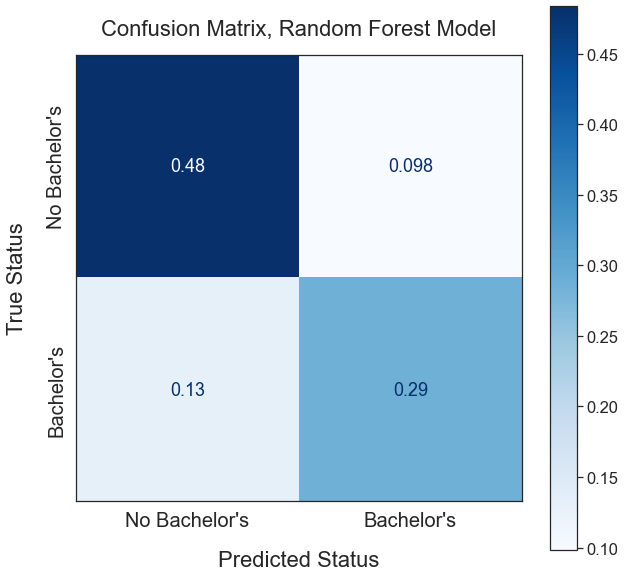

In [96]:
confusion_matrix(rf_best, X_train, X_val, y_val, weights, normalize="all", model_name = "Random Forest")

Here are the feature importances. Note that due to the nature of Random Forest, we would expect these to be less meaningful than the logistic regression coefficients as they measure the effect of splitting rather than the direct effect on probability of a feature. We also do not see whether a feature improves or decreases the chances of receiving a bachelor's degree.

In [111]:
rf_importances = sorted(zip(features, rf_best.feature_importances_), key=lambda x: -abs(x[1]))
rf_importances

[('wealth', 0.21076181767908614),
 ('math_score', 0.20934436297853787),
 ('reading_score', 0.16146814257575026),
 ('income', 0.16134688504069364),
 ('age', 0.09100842983320839),
 ('food_security', 0.0242518338158854),
 ('live_w_both_parents', 0.01801335428256948),
 ('environment_type_met_fringe', 0.017332349306012573),
 ('black', 0.016534099024730055),
 ('white_only', 0.01602868177052551),
 ('environment_type_met_small', 0.014112237403926055),
 ('hispanic', 0.014088399114152885),
 ('environment_type_met_central', 0.01323247362327501),
 ('environment_type_urb_met', 0.01151971665423704),
 ('environment_type_urb_nonmet', 0.007255184390912205),
 ('environment_type_rural', 0.006972057653659602),
 ('asian', 0.006729974852837819)]

### Logistic Regression Evaluation
Now let's look at LR.

In [80]:
best_lr_params = get_best_params(lr_scores, "fp5")
print_best_params(best_rf_params, keywords_rf, "fp5")

Classifier Params: [('n_estimators', 0.05), ('criterion', 'liblinear'), ('max_depth', 'l1'), ('min_samples_split', None)]
Sampler: None
Scaling: True
fp5 Score (CV): 0.7411364255970453


In [93]:
y_pred_lr = lr_best.predict(prepro(X_train, X_val, scale=True)[1])
print(metrics.classification_report(y_val, y_pred_lr, sample_weight=weights[y_val.index]))
print("fp5 score:", metrics.fbeta_score(y_val, y_pred_rf, beta=0.5, sample_weight=weights[y_val.index]))

              precision    recall  f1-score   support

           0       0.75      0.84      0.79 2972.9969999999976
           1       0.73      0.60      0.66 2135.5330000000004

    accuracy                           0.74 5108.529999999998
   macro avg       0.74      0.72      0.73 5108.529999999998
weighted avg       0.74      0.74      0.74 5108.529999999998

fp5 score: 0.7319542574258807


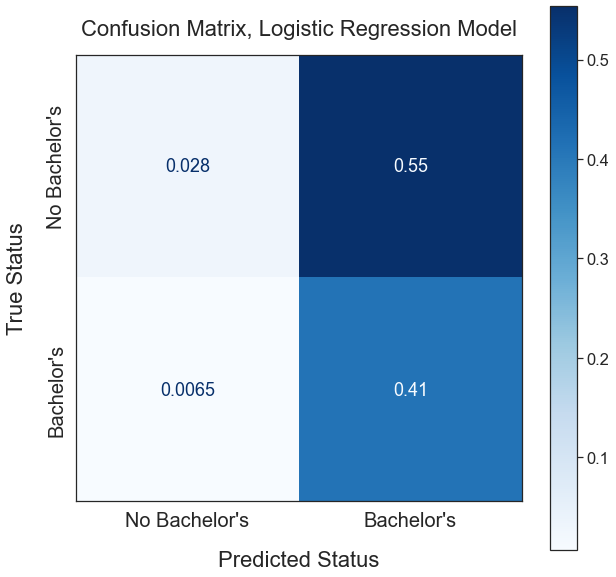

In [97]:
confusion_matrix(lr_best, X_train, X_val, y_val, weights, normalize="all", model_name = "Logistic Regression")

In [108]:
lr_importances = sorted(zip(features, lr_best.coef_[0]), key=lambda x: -abs(x[1]))
lr_importances

[('math_score', 0.8022618901178552),
 ('wealth', 0.7374922692848122),
 ('age', 0.524167081723923),
 ('reading_score', 0.49958200380108786),
 ('environment_type_urb_met', -0.33318645193601804),
 ('income', 0.2801956307036333),
 ('hispanic', 0.20747552695263366),
 ('environment_type_met_central', -0.18344415965184768),
 ('asian', 0.16637282858533278),
 ('environment_type_met_fringe', 0.14897489536308736),
 ('live_w_both_parents', 0.08501614485788578),
 ('food_security', -0.08404905453216234),
 ('black', -0.011645271506346217),
 ('white_only', 0.0019830556529086074),
 ('environment_type_met_small', 0.0),
 ('environment_type_rural', 0.0),
 ('environment_type_urb_nonmet', 0.0)]

### Feature Evaluation

Let's put the feature importances into dataframes, take the absolute value of the LR coefficients, then scale them to compare between RF and LR.

In [155]:
rf_feats = pd.DataFrame(rf_importances, columns=["rf_feature", "rf_imp"])
lr_feats = pd.DataFrame(lr_importances, columns=["lr_feature", "lr_coef"])
both_feats = rf_feats.merge(lr_feats, left_on=["rf_feature"], right_on=["lr_feature"]).drop(labels=["lr_feature"], axis=1).rename(columns={"rf_feature": "feature"})

scaler = StandardScaler()
both_feats["lr_coef"] = np.abs(both_feats["lr_coef"])
both_feats[["rf_imp","lr_coef"]] = scaler.fit_transform(both_feats[["rf_imp", "lr_coef"]])

both_feats

,feature,rf_imp,lr_coef
0,wealth,2.060842,1.986338
1,math_score,2.041616,2.244512
2,reading_score,1.392238,1.038021
3,income,1.390594,0.163540
4,age,0.436546,1.136018
5,food_security,-0.468919,-0.618307
6,live_w_both_parents,-0.553536,-0.614452
7,environment_type_met_fringe,-0.562773,-0.359510
8,black,-0.573600,-0.906910
9,white_only,-0.580455,-0.945424


We can compare the releative importance assigned to features by each here. We see largely similar values, though Asian, Age, and urb_met environment type do diverge, especially the last.

In [135]:
pd.concat([rf_feats, lr_feats], axis=1)

,feature,rf_imp,feature,lr_coef
0,wealth,0.210762,math_score,0.802262
1,math_score,0.209344,wealth,0.737492
2,reading_score,0.161468,age,0.524167
3,income,0.161347,reading_score,0.499582
4,age,0.091008,environment_type_urb_met,-0.333186
5,food_security,0.024252,income,0.280196
6,live_w_both_parents,0.018013,hispanic,0.207476
7,environment_type_met_fringe,0.017332,environment_type_met_central,-0.183444
8,black,0.016534,asian,0.166373
9,white_only,0.016029,environment_type_met_fringe,0.148975


### Feature Discussion

We see that the ordering diverges moderately, but that most of the very important features are captured by both.

Generally, we see that *wealth*, *income*, *math_score*, and *reading_score* are the most important features. Higher values for these features suggest a higher chance of receiving a bachelor's degree. 

As might be expected, increased age also improves the chances of receiving a degree; older people have more time to graduate from college.

Living in a city near a metropolis (```urb_met```) and living in a central, highly-populated metropolis (```met_central```) decrease one's chances of going to college significantly. 

Race has a moderate impact, though we would caution strongly against hasty interpretations of race here. We include race as a (set of) variables in order to gauge its predictivity for a model, and to spur a discussion of algorithmic fairness and bias. See the [presentation](../presentation/project_three_slides.pdf) for further details.

### Plotting Curves

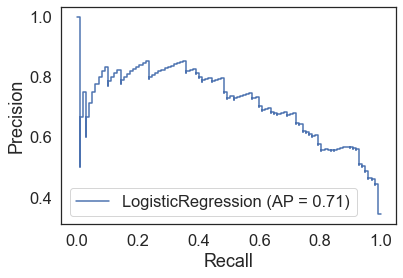

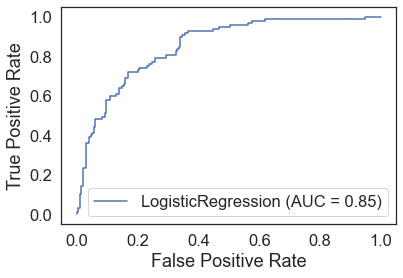

In [158]:
X_tr_prepro_sc, X_v_prepro_sc = prepro(X_train, X_val, scale=True)
X_tr_prepro, X_v_prepro = prepro(X_train, X_val)

sklearn.metrics.plot_precision_recall_curve(lr_best, X_v_prepro_sc, y_val)
sklearn.metrics.plot_roc_curve(lr_best, X_v_prepro_sc, y_val)

## Final Test Evaluation

We evaluate the Random Forest model that we have chosen on the previously unseen test set.

In [168]:
y_pred = rf_best.predict(prepro(X_train, X_test)[1])
    
fp5 = metrics.fbeta_score(y_test, y_pred, beta=0.5, sample_weight=weights[y_test.index])
acc = metrics.accuracy_score(y_test, y_pred, sample_weight=weights[y_test.index])
pre = metrics.precision_score(y_test, y_pred, sample_weight=weights[y_test.index])
rec = metrics.recall_score(y_test, y_pred, sample_weight=weights[y_test.index])
print("RF Test Scores", "| fp5: %.3f | acc: %.3f | pre: %.3f | rec: %.3f" % (fp5, acc, pre, rec))

RF Test Scores | fp5: 0.649 | acc: 0.713 | pre: 0.670 | rec: 0.574


We end with an f<sub>0.5</sub>-score of 0.649, with precision of 0.670 and recall of 0.574.